In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import math
from matplotlib import pyplot as plt
%matplotlib inline
import importlib 

datafolder = 'workdata'
paysdf = {}

In [2]:
# LOAD tables
payslist = ['France','Germany','Italy','Spain','Belgium','United Kingdom']
for paysname in payslist:
    filepath = datafolder+'/incidence_'+paysname+'_Table.csv'
    paysdf[paysname] = pd.read_csv(filepath)

testdf = paysdf['France']
testdf

,Confirmed,Deaths,Recovered,Active,Date,Confirmed_brutincidence,Confirmed_MMincidence,Confirmed_eMMincidence,Deaths_brutincidence,Deaths_MMincidence,Deaths_eMMincidence,Recovered_brutincidence,Recovered_MMincidence,Recovered_eMMincidence,Active_brutincidence,Active_MMincidence,Active_eMMincidence
0,0,0,0,0,2020-01-22 00:00:00,0,0.0,0.00,0,0.0,0.00,0,0.0,0.00,0,0.0,0.00
1,0,0,0,0,2020-01-23 00:00:00,0,0.0,0.00,0,0.0,0.00,0,0.0,0.00,0,0.0,0.00
2,2,0,0,2,2020-01-24 00:00:00,2,0.7,0.20,0,0.0,0.00,0,0.0,0.00,2,0.7,0.20
3,3,0,0,3,2020-01-25 00:00:00,1,0.8,0.28,0,0.0,0.00,0,0.0,0.00,1,0.8,0.28
4,3,0,0,3,2020-01-26 00:00:00,0,0.6,0.25,0,0.0,0.00,0,0.0,0.00,0,0.6,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,2160343,48341,155829,1956173,2020-11-20 00:00:00,23247,26884.9,32493.23,1140,626.3,584.11,2684,1879.7,1732.73,19423,24378.9,30223.85
304,2178023,48593,156755,1972675,2020-11-21 00:00:00,17680,24825.6,31011.90,252,611.7,550.90,926,1728.4,1652.06,16502,22485.4,28851.67
305,2191180,48807,157259,1985114,2020-11-22 00:00:00,13157,22815.4,29226.41,214,599.1,517.21,504,1704.7,1537.25,12439,20511.6,27210.40
306,2195940,49312,158170,1988458,2020-11-23 00:00:00,4760,22092.4,26779.77,505,598.6,515.99,911,1682.0,1474.63,3344,19811.9,24823.76


# ESTIMATION OF R PROCESS

In [3]:
# INCIDENCE SERIE (supplementary cases per days column)
# can be mesured on confirmedcases, hostitalisation cases, or reanimation cases
# as long as there is NO negative values
IncidenceSerie = testdf['Confirmed_MMincidence']  
TimeMaxnb = IncidenceSerie.shape[0]    
print('length of current time serie : {} days'.format(TimeMaxnb))

length of current time serie : 308 days


In [4]:
# =============================
#  PREDEFINED PARAMETERS
# =============================
# A - TYPE OF CALCULATION
UNCERTAINTY_FLAG = False
# FALSE will build the SI_distribution with only 'main' fixed values of input mean and std, it is fairly quick
# TRUE will build SI_distribution by iterating to find most probable value of MEAN and STD around main value,
# it is a lot slower

# PARAMETERS TO BUILD THE SERIAL INTERVAL DISTRIBUTION
# MAIN VALUES : mandatory for all types of computation
# must : SI_mean > 1; SI_mean > ComputationStep; SI_stdev > 0
SI_mean = 8.4
SI_stdev = 3.8

# UNCERTAINTY DISTRIBUTION PARAMETERS
# must : 
# mean_vars['std'] > 0 ;mean_vars['min'] > 1; mean_vars['min'] < SI_mean; mean_vars['MAX'] > SI_mean;
# stdev_vars['std'] > 0; stdev_vars['min'] > 0; stdev_vars['min'] < SI_stdev; stdev_vars['MAX'] > SI_stdev
mean_vars = {'std':1,
             'MAX':12.4,
             'min':4.4}
stdev_vars = {'std':0.5,
            'MAX':5.8,
            'min':1.8}

# must : SampleSizeSI > 0 ; must : posteriorSamplesize > 0
uncertaintySampleSize = 5
posteriorSamplesize = 5

# TIME INTERVALS FOR COMPUTATION
# must : CVThreshold > 0
# must  : ComputationLength > 1 ; ComputationLength < TimeMaxnb; ComputationStep > 1
# DETERMINE STARTING POINT : low values will skip more of the first days for computation
CVThreshold = 0.3 
# ComputationLength : average of R computation over a time frame (7 = average on 1 week)
ComputationLength=7
# ComputationStep >> 1 = every day ; 7 = every weeks
ComputationStep=1

#Prior starting values of mean/std
# must : MeanPrior >0 ; StdPrior >0
MeanPrior = 5
StdPrior = 5

all params and input check seems good


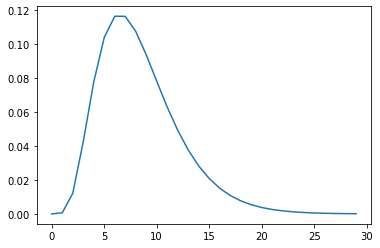

In [5]:
# ===============================
# Checks on INPUTS and PARAMETERS 
# ===============================
import utils_R
importlib.reload(utils_R)

GOLOOP_FLAG =True
if not UNCERTAINTY_FLAG :
    if not utils_R.fullcheck_serial(IncidenceSerie,SI_mean,SI_stdev,
                        MeanPrior,StdPrior,CVThreshold,
                        ComputationLength,ComputationStep) : GOLOOP_FLAG = False
    GOLOOP_FLAG,visuMeanSIFinal,visusdSIFinal,visuSIDistr = utils_R.FinalSIDistributionWithoutUncertainty(SI_mean,SI_stdev,TimeMaxnb)
    
    #VISUALISATION OF DISTRIBUTION
    stopplot = round(SI_mean+3*SI_stdev)
    for i in range(round(SI_mean),TimeMaxnb):
        if visuSIDistr[i]< 0.0001 : 
            stopplot = i
            break
    plt.plot(range(stopplot),visuSIDistr[0:stopplot])

else :
    if not utils_R.fullcheck_uncertain(IncidenceSerie,SI_mean,SI_stdev,
                           MeanPrior,StdPrior,CVThreshold,
                           ComputationLength,ComputationStep,
                           mean_vars,stdev_vars,uncertaintySampleSize) : GOLOOP_FLAG = False
        
if GOLOOP_FLAG : print('all params and input check seems good')
else : print('ERRORS in params and input check, verify and correct')

In [10]:
import R_Main
import importlib 
importlib.reload(R_Main)

<module 'R_Main' from '/home/delka/work/GitRepos/Rcomputing_covid19/R_Main.py'>

In [26]:
# COMPUTATION LOOP OF R ON SEVERAL INCIDENCE DATASET !
resultframe = {}
for paysname in payslist:
    IncidenceSerie = paysdf[paysname]['Confirmed_MMincidence']  
    TimeMaxnb = IncidenceSerie.shape[0]    
    print('length of current time serie for {} : {} days'.format(paysname,TimeMaxnb))
    
    if not UNCERTAINTY_FLAG :
        resultframe[paysname] = R_Main.Rloop(IncidenceSerie,MeanPrior,StdPrior,SI_mean, SI_stdev,
                             CVThreshold,ComputationLength,ComputationStep)
    else :
        resultframe[paysname] = R_Main.Rloop_I(IncidenceSerie,MeanPrior,StdPrior,SI_mean, SI_stdev,mean_vars,stdev_vars,
                             CVThreshold,ComputationLength,ComputationStep,
                               uncertaintySampleSize,posteriorSamplesize)
    
    writefilepath = datafolder+'/resultframe_'+paysname+'_Table.csv'
    resultframe[paysname].to_csv(writefilepath,index=False)

length of current time serie for France : 308 days
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
computation complete
length of current time serie for Germany : 308 days
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
computation complete
length of current time serie for Italy : 308 days
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
computation complete
length of current time serie for Spain : 308 days
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
computation complete
length of current time serie for Belgium : 308 days
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
computation complete
length of current time serie for United Kingdom : 308 d

In [27]:
# exemple of result frame
resultframe['France']

,timestep,incidence,aPosterior,bPosterior,MeanR,StdR,RQuantile025,RQuantile05,RQuantile25,Rmedian,RQuantile75,RQuantile95,RQuantile975
21,22,0.7,4.7,0.325097,1.527957,0.704794,0.474015,0.580083,1.013174,1.421065,1.926831,2.840831,3.187579
22,23,0.7,5.3,0.339767,1.800763,0.782201,0.609164,0.733704,1.230707,1.688862,2.249403,3.249884,3.626651
23,24,0.7,5.9,0.349185,2.060191,0.848167,0.748086,0.889471,1.443360,1.945038,2.552015,3.624040,4.025199
24,25,0.1,5.3,0.350184,1.855978,0.806185,0.627842,0.756201,1.268442,1.740646,2.318374,3.349532,3.737851
25,26,0.1,4.7,0.341444,1.604789,0.740234,0.497850,0.609252,1.064121,1.492522,2.023720,2.983679,3.347863
...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,304,26884.9,208980.8,0.000003,0.671777,0.001470,0.668900,0.669362,0.670786,0.671776,0.672768,0.674196,0.674661
304,305,24825.6,191739.1,0.000003,0.632613,0.001445,0.629785,0.630239,0.631638,0.632612,0.633587,0.634991,0.635448
305,306,22815.4,186513.8,0.000003,0.636440,0.001474,0.633555,0.634018,0.635445,0.636439,0.637433,0.638866,0.639331
306,307,22092.4,182139.6,0.000004,0.647022,0.001516,0.644054,0.644530,0.645999,0.647021,0.648044,0.649517,0.649997


In [35]:
# CREATE MEANR TABLE for plotting (STARTING AT minimum incidence value)
Rmedian ={}
for paysname in payslist:
    currentframe = resultframe[paysname]
    # FIRST TIME INCIDENCE > 100
    startval = 0
    for i,row in currentframe.iterrows():
        if row['incidence']>1000 : 
            startval = i
            break     
    print(paysname,startval)
    #FILTER DATAFRAME ACCORDINGLY
    currentframe = currentframe.loc[(currentframe.index >= startval)]

    #GET NEEDED VALUES
    currentlist = currentframe['Rmedian']
    Rmedian[paysname] = currentlist

France 57
Germany 55
Italy 47
Spain 53
Belgium 67
United Kingdom 56


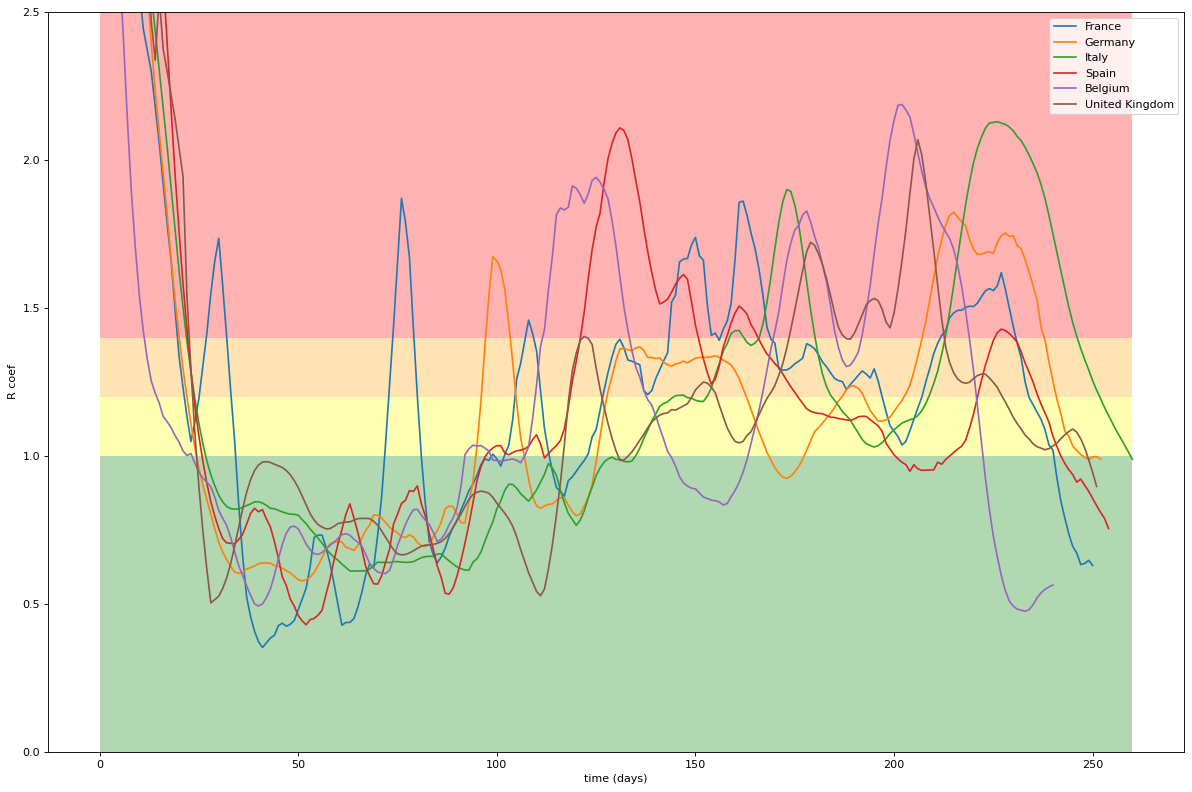

In [50]:
from matplotlib.pyplot import figure
# ABSCISSE SELECTION
xlength = 0
for paysname in payslist:
    if Rmedian[paysname].shape[0] > xlength : 
        xlength = Rmedian[paysname].shape[0]
X = range(xlength)

#figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots(figsize=(15, 10), dpi=80)

ax1.set_xlabel('time (days)')
ax1.set_ylabel('R coef')
#ax1.axhline(1.0,c='green', linewidth=2, linestyle='-')
ax1.fill_between(X, 0, 1.0,facecolor='green',alpha=0.3)
ax1.fill_between(X, 1.0, 1.2,facecolor='yellow',alpha=0.3)
ax1.fill_between(X, 1.2, 1.4,facecolor='orange',alpha=0.3)
ax1.fill_between(X, 1.4, 2.5,facecolor='red',alpha=0.3)

for paysname in payslist:
    X=range(Rmedian[paysname].shape[0])
    Y=Rmedian[paysname]
    ax1.plot(X,Y,label=paysname) # plt.plot(x, y, "y-", color=colors[i%2])

#legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
legend = ax1.legend()
ax1.set_ylim([0, 2.5])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

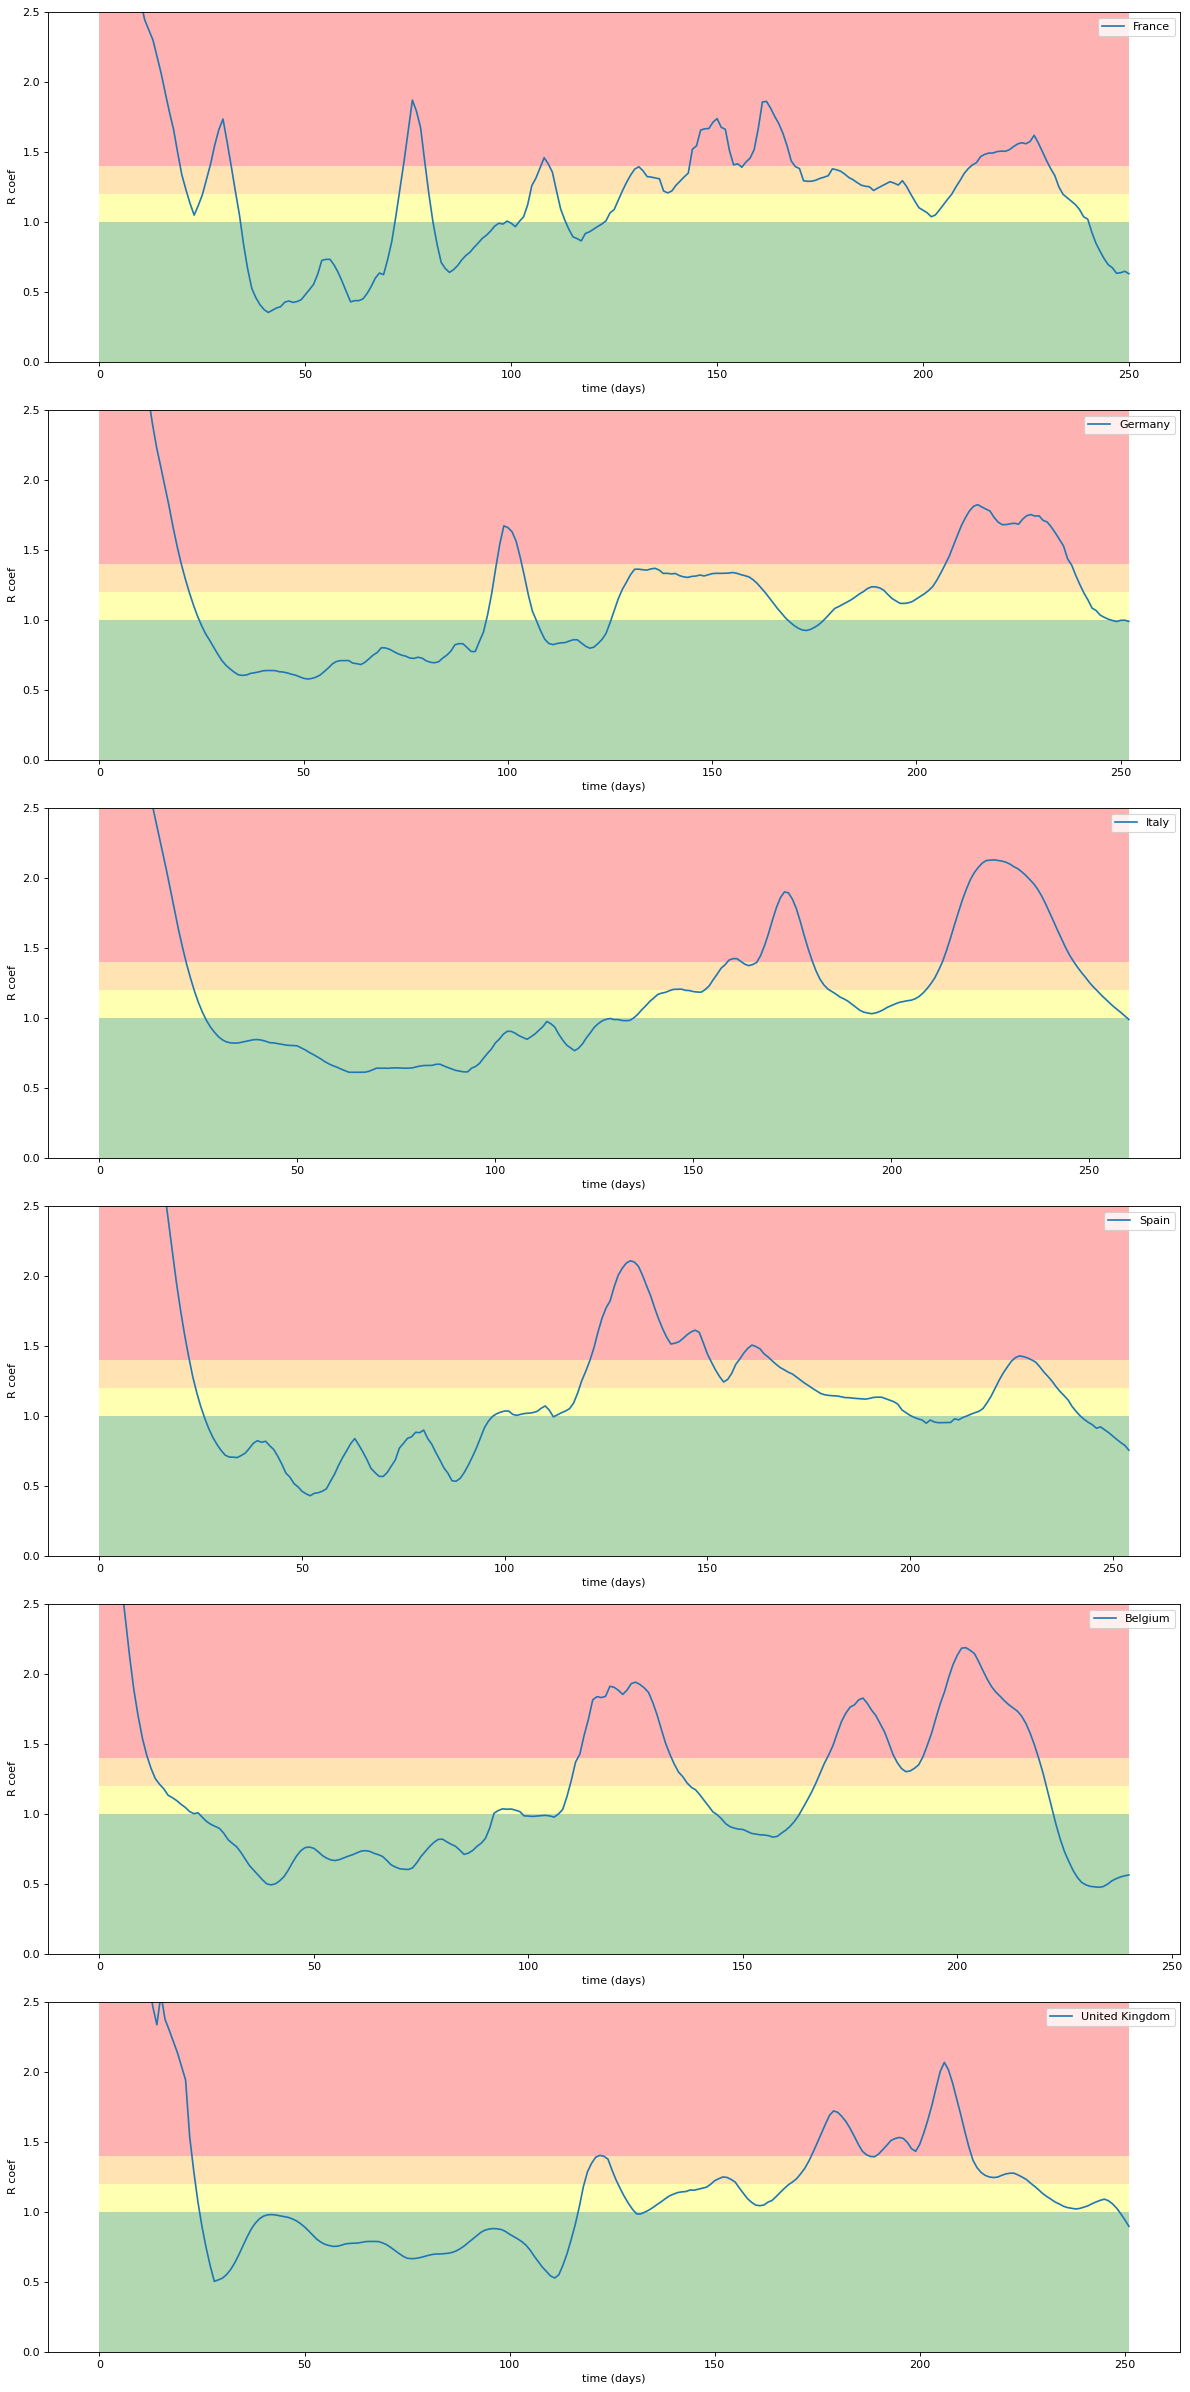

In [49]:
from matplotlib.pyplot import figure
# ABSCISSE SELECTION
xlength = 0
for paysname in payslist:
    if Rmedian[paysname].shape[0] > xlength : 
        xlength = Rmedian[paysname].shape[0]
X = range(xlength)

#figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(len(payslist),1,figsize=(15, 30), dpi=80)
for paysname,ax1 in zip(payslist,axs.flatten()):
    ax1.set_xlabel('time (days)')
    ax1.set_ylabel('R coef')

    X=range(Rmedian[paysname].shape[0])
    Y=Rmedian[paysname]
    ax1.plot(X,Y,label=paysname)
    
    #ax1.axhline(1.0,c='green', linewidth=2, linestyle='-')
    ax1.fill_between(X, 0, 1.0,facecolor='green',alpha=0.3)
    ax1.fill_between(X, 1.0, 1.2,facecolor='yellow',alpha=0.3)
    ax1.fill_between(X, 1.2, 1.4,facecolor='orange',alpha=0.3)
    ax1.fill_between(X, 1.4, 2.5,facecolor='red',alpha=0.3)

    #legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
    ax1.legend()
    ax1.set_ylim([0, 2.5])
    
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

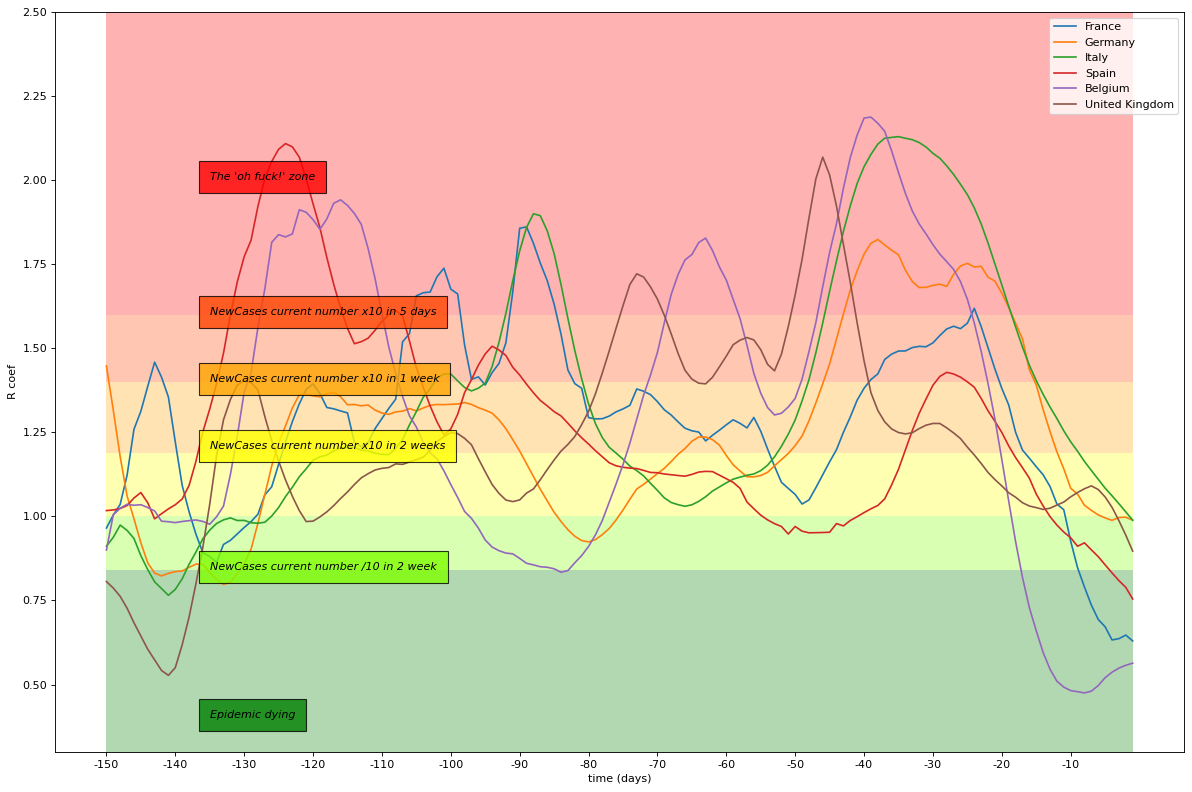

In [95]:
from matplotlib.pyplot import figure
# ABSCISSE SELECTION
# VISUALISATION
rangeselection = 150
if rangeselection <= resultframe['France'].shape[0] :
    index = resultframe['France'].index[-1]-rangeselection
    middleval = resultframe['France'].index[-1]-rangeselection*9/10
else : index = 0
#print(index)
#print(index)
X = range(index,resultframe['France'].index[-1])

#figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots(figsize=(15, 10), dpi=80)

ax1.set_xlabel('time (days)')
ax1.set_ylabel('R coef')
#ax1.axhline(1.0,c='green', linewidth=2, linestyle='-')
ax1.fill_between(X, 0, 0.84,facecolor='green',alpha=0.3)
ax1.fill_between(X, 0.84, 1.0,facecolor='chartreuse',alpha=0.3)
ax1.fill_between(X, 1.0, 1.19,facecolor='yellow',alpha=0.3)
ax1.fill_between(X, 1.19, 1.4,facecolor='orange',alpha=0.3)
ax1.fill_between(X, 1.4, 1.6,facecolor='orangered',alpha=0.3)
ax1.fill_between(X, 1.6, 2.5,facecolor='red',alpha=0.3)

ax1.text(middleval,0.84, 'NewCases current number /10 in 2 week', style='italic',
        bbox={'facecolor': 'chartreuse', 'alpha': 0.8, 'pad': 10})
ax1.text(middleval,0.4, 'Epidemic dying', style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.8, 'pad': 10})
ax1.text(middleval,1.2, 'NewCases current number x10 in 2 weeks', style='italic',
        bbox={'facecolor': 'yellow', 'alpha': 0.8, 'pad': 10})
ax1.text(middleval,1.4, 'NewCases current number x10 in 1 week', style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.8, 'pad': 10})
ax1.text(middleval,1.6, 'NewCases current number x10 in 5 days', style='italic',
        bbox={'facecolor': 'orangered', 'alpha': 0.8, 'pad': 10})
ax1.text(middleval,2.0, "The 'oh fuck!' zone", style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 10})


for paysname in payslist:
    Y=resultframe[paysname].loc[resultframe[paysname].index > index]['Rmedian']
    ax1.plot(X,Y,label=paysname) # plt.plot(x, y, "y-", color=colors[i%2])

#legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
legend = ax1.legend()
ax1.set_ylim([0.3, 2.5])

ax1.set_xticks(np.arange(index,resultframe['France'].index[-1], step=10))
ax1.set_xticklabels(np.arange(-rangeselection, 0, step=10))
#plt.xticks(X[,np.arange(-rangeselection, 0, step=10))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()